In [517]:
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [455]:
# Load the dataset
df_o = pd.read_csv('./data/USvideos.csv', )
df = df_o.copy()

### Dataset Description ###  
This dataset contains stats on daily trending, U.S. based videos posted on YouTube. There are 40,949 records - each representing a trending video post. Video posts can be trending on multiple days, so the number of actual - unique video post os 6,351. Each video post in the dataset contains 16 features, including: views, likes, dislikes, comment count, title, description, tags, publish date, trending date, etc. 

In [456]:
#unique videos
df_o['video_id'].describe()['unique']

6351

### Variable Description

**1. Category ID:** The category of the video.  
**2. Views:** On average, the videos in this dataset received 2,360,784 views. The median received 681,861; while the max received 225,211,923. The outliers are driving the average higher.   
**3. Likes:** Likes variable share similar charecteristics as views.  
**4. Dislikes:** Dislikes variable share similar charecteristics as views.    
**5. Comment Count:** Comments variable share similar charecteristics as views.    

In [457]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count
count        40949      40949    40949     40949          40949
mean            19    2360784    74266      3711           8446
std              7    7394113   228885     29029          37430
min              1        549        0         0              0
25%             17     242329     5424       202            614
50%             24     681861    18091       631           1856
75%             25    1823157    55417      1938           5755
max             43  225211923  5613827   1674420        1361580


In [458]:
# What are the column types?
# Descriptive stats of Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled. 
print(df.dtypes.sort_values())

comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
category_id                int64
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
video_id                  object
trending_date             object
title                     object
channel_title             object
publish_time              object
tags                      object
thumbnail_link            object
description               object
dtype: object


### Variables Summary ###
Dataset seems to have large outliers that are driving these numbers out of wack.  
  
Descriptive stats for Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled. Additionally, there are dups in the dataset as videos can be trending on multiple days.
Normalizing the stats by eliminating those videos that have disabled ratings and comments, and consolidating dups, might make the dataset more useful.  

### What's the goal? ###  
**VIEWS** is the currency of YouTubers. The more views one gets, the more subscribers, followers and money they make. Our goal is to ask questions in relation to views.  

While the variables that the dataset provided seems useful, I'd like to know the video length to do analysis on views. I suspect that shorter videos receive more views, reiviews and/or comments. If that is the case, then when we post videos on YT, our video length should be within that range that experiences more views.
  
In order to answer this question, we must reach out to YouTube - either by scraping the length of each video or accessing the YT API to get this data.  
  
Additionally, once we normalize the data and retrieve all the additional variables through scraping and feature engineering, we'll run a regression analysis to better understand the relationship and impact of the variables on video views.  

### Data Wrangling Plan & Questions ###  
**Tags:** How many tags does each video have? Does the more tags a video have garner more views, given its more discoverable? Does having an overwhelming amount of tag hurt you?  
  
**Description:** Does the length of the description help or hurt views?  
  
**Title:** Does the length of the title play a role in receiving more views? Do similar titles cannabalize views?  
  
**Channel Title:** Are there similar sounding channels? Maybe too many similar sounding channels cannabalize each others views?

**Publish and Trending Date:** On average, how long does it take for a video to go treding? What are the characteristics of the videos with the long lead time vs those with short lead time?  

### Formatting Dates for Conditionals ###  
Both variables need to be normalized as they are both in different formats.  
We will get the difference between trending and publish date. This will give us insight into, on average, how long do we have to wait for our video to go trending? Additionally, what is the relationship between trending lead time and the length of the video? Do shorter videos trend faster?  
  
Additionally, we will tease out the time it was published. For videos that trend on the same date it was published, the time it was published might give us an insight into when we should release our video to the public. I assume that prime time is the best time to publish.

In [459]:
df[['publish_time', 'trending_date']][10:20]

,publish_time,trending_date
10,2017-11-13T02:05:26.000Z,17.14.11
11,2017-11-13T03:00:00.000Z,17.14.11
12,2017-11-13T17:00:00.000Z,17.14.11
13,2017-11-12T14:00:00.000Z,17.14.11
14,2017-11-12T18:30:01.000Z,17.14.11
15,2017-11-13T20:09:58.000Z,17.14.11
16,2017-11-12T17:00:05.000Z,17.14.11
17,2017-11-13T16:00:07.000Z,17.14.11
18,2017-11-13T15:30:17.000Z,17.14.11
19,2017-11-12T22:00:01.000Z,17.14.11


**Create singleton, lambda functions**

In [460]:
getTime = lambda x: str(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').time())
getDate = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').date()
getDateFormatted = lambda x: getDate(datetime.datetime(int(x[0:2]), int(x[6:8]), int(x[3:5])).strftime('20%y-%m-%dT%H:%M:%S.000Z'))
getDateDifference = lambda x: x.days

**Apply functions to Dataset to create new variables**

In [461]:
df['publish_time_date'] = df['publish_time'].apply(getDate)
df['publish_time_time_use'] = df['publish_time'].apply(getTime)
df['trending_date_date'] = df['trending_date'].apply(getDateFormatted)
df['trend_lead_use'] = (df['trending_date_date'] - df['publish_time_date']).apply(getDateDifference)

### Dealing W/ Duplicate Videos ###  
There are approximately 6.3k unique videos in this dataset. Each video may be trending on multiple days, therefore - the stats provided are additive. View statistics for a video that is trending for 30 days are a running sum. 

**Dup Functions**  
getDups: Get how many "duplicate" rows does a certain video post have. The amount of "duplicate" rows it has signifies the amount of trending days.  
getFirstTrendStats: Get the date when the video first went trending. As well as the first trending day's views, likes, dislikes, comments


In [462]:
getDups = lambda x: len(df[df['video_id'] == x])

def getFirstTrendStats(x):
    items = ['trending_date_date', 'views', 'likes', 'dislikes', 'comment_count']
    return [df[df['video_id'] == x['video_id']].sort_values(by=['trending_date_date'])[:1][i].values[0] for i in items]

**Get the amount of trending days**

In [463]:
df['trending_days'] = df['video_id'].apply(getDups)

**Get the stats of the first trending day**

In [464]:
cols = df.apply(getFirstTrendStats, axis=1, result_type='expand')
df['trending_date_first'] = cols[0]
df['views_first'] = cols[1]
df['likes_first'] = cols[2]
df['dislikes_first'] = cols[3]
df['comments_first'] = cols[4]

**Get all last trending day records. This will contain all unique video posts, without duplicates, which will hopefully be a more accurate dataset to work with.**

In [465]:
df_u = pd.DataFrame(df['video_id'].unique(), columns=['video_id'])

In [466]:
#& (df['trending_date_date'] == df[df['video_id'] == x['video_id']]['trending_date_date'].max())
df_use = df_u.apply(lambda x: df[(df['video_id'] == x['video_id']) & (df['trending_date_date'] == df[df['video_id'] == x['video_id']]['trending_date_date'].max())][:1].values[0], axis=1, result_type='expand')
df_use.columns = df.columns.tolist()
df_use.shape

(6351, 26)

In [467]:
df = df_use

In [485]:
df['trend_lead_use'] = (df['trending_date_first'] - df['publish_time_date']).apply(getDateDifference)

### Data Cleaning ###

**Tags**  
Tags look like they are seperated by the pipe symbol. Each tag after the first tag has quotes which should be scrubed.  
We'll create a column to seperate and count each tag, as well as count duplicate tags.

In [474]:
df['tags'][10:20]

10    NFL|"Football"|"offense"|"defense"|"afc"|"nfc"...
11    The Walking Dead|"shiva"|"tiger"|"king ezekiel...
12    marshmello|"blocks"|"marshmello blocks"|"block...
13    nowthis|"nowthis world"|"world news"|"nowthis ...
14    shopping for new fish|"new fish"|"aquarium fis...
15    Robots|"Boston Dynamics"|"SpotMini"|"Legged Lo...
16    pacific rim|"pacific rim 2"|"pacific rim seque...
17    TED|"TED-Ed"|"TED Education"|"TED Ed"|"Hilary ...
18    ultralight|"airplane"|"homemade"|"DIY"|"hoverb...
19    SciShow|"science"|"Hank"|"Green"|"education"|"...
Name: tags, dtype: object

In [475]:
# One time functions
cleanTags = lambda x: x.lower().replace('"','').split('|')
checkDups = lambda x: {i:cleanTags(x).count(i) for i in cleanTags(x)}

In [476]:
# Generate additional tag fields
df['tags_clean'] = df['tags'].apply(cleanTags)
df['tags_count_use'] = df['tags'].apply(cleanTags).apply(len)
df['tags_dups'] = df['tags'].apply(checkDups)
df['tags_dups_count_use'] = df['tags_dups'].apply(dict.values).apply(max)

**Description**  
Very unscrutured. The only thing we can get from here is the length of the string.  
  
For additional analysis, we should see if the tags are present in the description. This will help us answer the question: are tags an addition to the description or should they contain duplicate terms.

In [477]:
df['description_count_use'] = df['description'].apply(str).apply(lambda x: len(x))

**Title**   
Similar to Description, we should get the length of the title.  
  
For additional analysis, we should see if the tags are present in the title. If so, what position in the title does the tag take: beginning, middle, end? This will help us answer the question: are tags an addition to the title or should they contain duplicate terms. Also, this analysis could help us understand the importance of tags - do the search algorithm prioritize search results based on tag relevancy to the title?

In [478]:
df['tile_count_use'] = df['title'].apply(str).apply(lambda x: len(x))

### Review New Variables ###
Off the bat, looking at the new variables, we can clearly see that the duplicate tags calculation we generate gives us no data: almost all video posts do not have duplicate tags. We will not be using this variable.  
  
Additionally, some outlier analysis must be done to the trend lead variable as 75% of the video posts in this dataset had at least a 9 day trend lead. However, there are some or one exception: a max of 4,215 trend lead. We should look into this/these video post(s) and discard or fix the result to be able to use this variable efficiently.

The rest of the other variables look decent enough to continuie working with.

In [488]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count  \
count         6351       6351     6351      6351           6351   
mean            20    1962117    55575      3067           6450   
std              7    7060057   193830     31988          33823   
min              1        559        0         0              0   
25%             17     159156     2772       127            372   
50%             24     518107    11906       444           1266   
75%             25    1473581    38428      1507           4061   
max             43  225211923  5613827   1674420        1361580   

       trend_lead_use  trending_days  views_first  likes_first  \
count            6351           6351         6351         6351   
mean               22              6       758209        34493   
std               209              4      1928993       116243   
min                -1              1          549            0   
25%                 1              3        83511         1908   


### Features for Analysis ###

In [620]:
#features = ['views', 'likes', 'dislikes', 'comment_count', 'tags_count_use', 'description_count_use','tile_count_use', 'trend_lead_use']
df_use = df

In [510]:
df_wRatings = df_use[df_use['ratings_disabled']==True]
df_wComments = df_use[df_use['comments_disabled']==True]
df_use = df_use[(df_use['comments_disabled']==False) & (df_use['ratings_disabled']==False)]

### Views Feature ###  
As mentioned above, the Views feature is out of wack given the large outliers. In order to go into a deeper analysis, I'll have to do some outlier analysis - whether fixing the values or discarding.

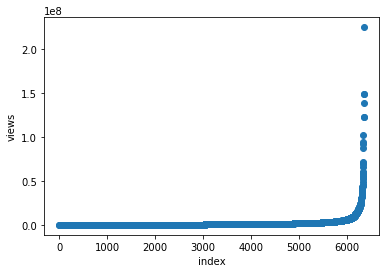

In [527]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df_use.index, np.sort(df_use['views']))
ax.set_xlabel('index')
ax.set_ylabel('views')
plt.show()

**The dataset includes videos from different categories.**  
Obviously, some categories will receive more views than others. For example, the top viewed videos were in the music category. If we compare our videos to the whole dataset, we will be comparing apples and oranges and will be getting garbage results.

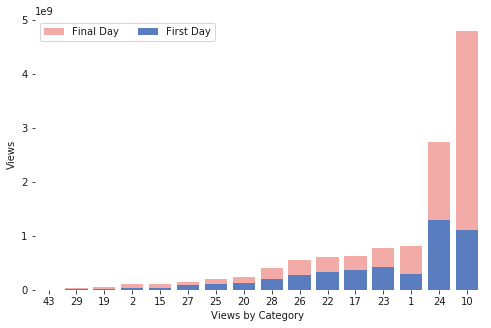

In [618]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set_color_codes("pastel")
sns.barplot(x='category_id', y='views', data=df_use.groupby(['category_id']).sum().reset_index(),
            label="Final Day", color="r", order=df_use.groupby(['category_id']).sum().reset_index().sort_values(by='views')['category_id'])

#Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="category_id", y="views_first", data=df_use.groupby(['category_id']).sum().reset_index(),
            label="First Day", color="b", order=df_use.groupby(['category_id']).sum().reset_index().sort_values(by='views')['category_id'])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set(ylabel="Views",
       xlabel="Views by Category")
sns.despine(left=True, bottom=True)

We can see here the difference between aggregate view count per category. Category 10 (Music) and 24 (Entertainment) dominate the trending scene. This makes sense since musicians and entertainers bring their own fan base, which helps their view stats.  
  
Since we are not making entertainment nor music videos, it will be best to eliminate these 2 categories from our analysis as, we would be comparing apples to oranges.

In [621]:
df_use = df_use[(df_use['category_id'] != 24) & (df_use['category_id'] != 10)]

### Quick Visuals to Measure Relationships ###  
The strongest correlation we can glean exists between the original variables. Correlation between the original variables and new variables seem to be non existent.

In [622]:
def getCorrHeatmap():
    corr = df_use.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

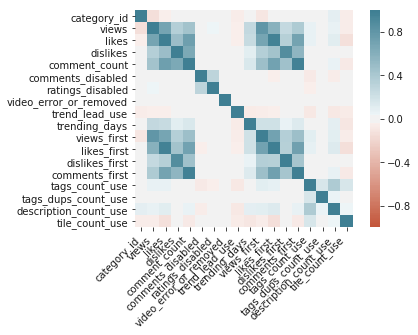

In [623]:
getCorrHeatmap()

**Deeper Dive into Relationships**